# Chargement des données et imports des librairies

In [1]:
# Importer les libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [2]:
# Chargement des données
data_csv = pd.read_csv('rapports-accident-2020.csv')
# Affichage d'un extrait du dataset
data_csv.head()

,AN,NO_SEQ_COLL,DT_ACCDN,HR_ACCDN,JR_SEMN_ACCDN,gravite,NB_MORTS,NB_BLESSES_GRAVES,NB_BLESSES_LEGERS,NB_VICTIMES_TOTAL,...,nb_tous_autobus_minibus,nb_bicyclette,nb_cyclomoteur,nb_motocyclette,nb_taxi,nb_urgence,nb_motoneige,nb_VHR,nb_autres_types,nb_veh_non_precise
0,2020,2020 _ 1,2020-05-09,09:00:00-09:59:00,SA,Léger,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020,2020 _ 2,2020-02-07,11:00:00-11:59:00,VE,Dommages matériels seulement,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020,2020 _ 3,2020-06-01,12:00:00-12:59:00,LU,Dommages matériels seulement,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020,2020 _ 4,2020-06-01,14:00:00-14:59:00,LU,Dommages matériels seulement,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020,2020 _ 5,2020-11-26,07:00:00-07:59:00,JE,Grave,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Pré-traitement du dataset


## 1ere analyse du dataset

In [3]:
# Taille du dataset
n_obs, n_attr = data_csv.shape
print("Le dataset contient", n_obs,"observations et", n_attr,"attributs.")

# Création d'une copie du dataframe qu'on utilisera dans la suite
df_data = data_csv.copy()

# Suppression des variables non pertinentes pour notre analyse
df_data.drop(['AN','NO_SEQ_COLL','NB_MORTS','NB_BLESSES_GRAVES','NB_BLESSES_LEGERS','NB_VICTIMES_TOTAL', 
               'NB_DECES_PIETON','NB_BLESSES_PIETON', 'NB_VICTIMES_PIETON','NB_DECES_MOTO','NB_BLESSES_MOTO','NB_VICTIMES_MOTO', 'NB_DECES_VELO',
               'NB_BLESSES_VELO','NB_VICTIMES_VELO', 'NO_CIVIQ_ACCDN','SFX_NO_CIVIQ_ACCDN','RUE_ACCDN','ACCDN_PRES_DE','CD_PNT_CDRNL_ROUTE',
               'NB_METRE_DIST_ACCD','CD_PNT_CDRNL_REPRR','CD_SIT_PRTCE_ACCDN','BORNE_KM_ACCDN'], axis=1, inplace=True)

Le dataset contient 95088 observations et 60 attributs.


In [4]:
# Définition des variables qualitatives et quantitatives
for col in df_data:
      if col.startswith('CD_') or col.startswith('NO_') or col.startswith('TP_'): # Les attributs CD_ correspondent à des codes et non des variables quantitatives
            df_data[col] = df_data[col].astype(str).replace('nan',np.nan)

df_data.dtypes

DT_ACCDN                        object
HR_ACCDN                        object
JR_SEMN_ACCDN                   object
gravite                         object
NB_VEH_IMPLIQUES_ACCDN         float64
CD_MUNCP                        object
REG_ADM                         object
MRC                             object
TP_REPRR_ACCDN                  object
NO_ROUTE                        object
VITESSE_AUTOR                  float64
CD_GENRE_ACCDN                  object
CD_ETAT_SURFC                   object
CD_ECLRM                        object
CD_ENVRN_ACCDN                  object
CD_CATEG_ROUTE                  object
CD_ETAT_CHASS                   object
CD_ASPCT_ROUTE                  object
CD_LOCLN_ACCDN                  object
CD_POSI_ACCDN                   object
CD_CONFG_ROUTE                  object
CD_ZON_TRAVX_ROUTR              object
CD_COND_METEO                   object
nb_automobile_camion_leger     float64
nb_camionLourd_tractRoutier    float64
nb_outil_equipement      

In [5]:
# Configuration de certains attributs

#  Extraction du mois
df_data['MOIS_ACCDN'] = pd.DatetimeIndex(df_data['DT_ACCDN']).month_name() 
df_data.drop(['DT_ACCDN'], axis=1, inplace=True)
# Nouvelles categories pour GRAVITE
df_data.replace({'gravite': {'Dommages matériels seulement':'Dommages_materiels', 'Dommages matériels inférieurs au seuil de rapportage':'Dommages_materiels','Léger': "Leger", 'Grave': 'Grave','Mortel': 'Mortel'} }, 
                               inplace = True)

# Nouvelles categories pour TP_REPRR_ACCDN
df_data.replace({'TP_REPRR_ACCDN': {'1.0':'Intersection', '2.0':'Autre_repere','0.0': "Autre_repere"} }, 
                               inplace = True)

# Ajout de l'information sur le type d'accident (Créatio d'un nouvel attribut)
code_collision_objet = [*range(38,59,1)]
code_collision_animal = [35,36,37]
code_collision_personne = [32,33]
code_collision_sanscollision = [*range(71,99,1)]

def category_genre_accdn(s):
    if s == 'nan' or s != np.nan:
        return "Non_precise" 
    elif int(float(s)) in code_collision_objet:
        return "Collision_objet"
    elif int(float(s)) in code_collision_animal:
        return "Collision_animal"
    elif int(float(s)) in code_collision_personne:
        return "Collision_personne"
    elif int(float(s)) in code_collision_sanscollision:
        return "Sans_collision"
    else:
        return "Non_precise" 
df_data['CD_GENRE_ACCDN_CAT'] = df_data['CD_GENRE_ACCDN'].apply(category_genre_accdn)

## Analyse des données manquantes

In [6]:
# Calcul du nombre de données manquantes par attributs
def get_nan_df(df):
    '''
      Fonction permettant de calculer le nombre et le taux de données manquantes
      dans un dataframe

      INPUT
      -----
      df : dataframe

      OUTPUT
      -----
      dataframe avec la liste des attributs ('attribut'), le nombre de données manquantes ('nan_counts')
      et le taux de données manquantes pour l'attribut ('nan_rate)
    '''
    col_names, nan_count, nan_rate = [], [], []
    for col in df.columns:
        col_names.append(col)
        count_nan = df[col].isna().sum()
        nan_count.append(count_nan)
        nan_rate.append(count_nan/df[col].shape[0])
  
    df_nan = pd.DataFrame(list(zip(col_names, nan_count, nan_rate)), columns=['attribut', 'nan_counts', 'nan_rate'])
    return df_nan.sort_values('nan_rate',ascending=False).reset_index(drop=True)

df_nan = get_nan_df(df_data)
df_nan

,attribut,nan_counts,nan_rate
0,CD_ZON_TRAVX_ROUTR,92743,0.975339
1,CD_POSI_ACCDN,73835,0.776491
2,CD_ETAT_CHASS,72915,0.766816
3,NO_ROUTE,59831,0.629217
4,TP_REPRR_ACCDN,43600,0.458523
5,VITESSE_AUTOR,15604,0.164101
6,CD_LOCLN_ACCDN,5526,0.058115
7,CD_CONFG_ROUTE,4559,0.047945
8,CD_COND_METEO,1351,0.014208
9,CD_ECLRM,1325,0.013934


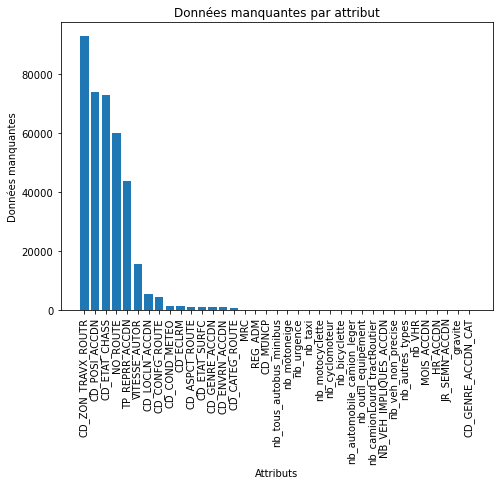

In [7]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_nan['attribut'],df_nan['nan_counts'])
plt.xticks(rotation=90)
ax.set_ylabel('Données manquantes')
ax.set_xlabel('Attributs')
ax.set_title('Données manquantes par attribut')
plt.show()

### Cas "Trop de données manquantes": Suppression 

In [8]:
# Suppression des attributs avec plus de 50% de données manquantes
NAN_RATE_MAX = 0.5
attr_many_nan = list(df_nan.loc[df_nan['nan_rate'] > NAN_RATE_MAX, 'attribut'])
print('Les attributs avec plus de 50% de données manquantes sont : ',attr_many_nan)
df_data.drop(attr_many_nan, axis=1, inplace=True)
df_data.dtypes

Les attributs avec plus de 50% de données manquantes sont :  ['CD_ZON_TRAVX_ROUTR', 'CD_POSI_ACCDN', 'CD_ETAT_CHASS', 'NO_ROUTE']


HR_ACCDN                        object
JR_SEMN_ACCDN                   object
gravite                         object
NB_VEH_IMPLIQUES_ACCDN         float64
CD_MUNCP                        object
REG_ADM                         object
MRC                             object
TP_REPRR_ACCDN                  object
VITESSE_AUTOR                  float64
CD_GENRE_ACCDN                  object
CD_ETAT_SURFC                   object
CD_ECLRM                        object
CD_ENVRN_ACCDN                  object
CD_CATEG_ROUTE                  object
CD_ASPCT_ROUTE                  object
CD_LOCLN_ACCDN                  object
CD_CONFG_ROUTE                  object
CD_COND_METEO                   object
nb_automobile_camion_leger     float64
nb_camionLourd_tractRoutier    float64
nb_outil_equipement            float64
nb_tous_autobus_minibus        float64
nb_bicyclette                  float64
nb_cyclomoteur                 float64
nb_motocyclette                float64
nb_taxi                  

In [9]:
# Supprimer les accidents dont on a moins de 33% des informations
ROW_NAN_RATE = 0.33
percent_row = df_data.count(axis=1)/ len(df_data.columns)
index_row = percent_row[percent_row < ROW_NAN_RATE].index
print(index_row)
if len(index_row) > 0:
    for i in range(len(index_row)):
        df_data.drop([index_row[i]], inplace=True)
df_data.shape

Int64Index([5492, 11446, 12644, 41468, 41772, 46627], dtype='int64')


(95082, 33)

### Cas "Quelques données manquantes" : Remplissage

In [10]:
gb = df_data.groupby('gravite')    
test = [gb.get_group(x) for x in gb.groups]
test[1].head()
test_2 = pd.concat(test, axis=0)
test_2.shape

(95082, 33)

In [11]:
def fill_missing_values(df):
    '''
      Fonction permettant de remplacer les données manquantes dans un dataframe
    
      INPUT
      -----
      df : dataframe

      OUTPUT
      -----
      dataframe rempli avec la valeur médiane pour les attributs quantitatifs et la valeur la plus fréquence 
      pour les attributs catégoriques
    '''
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col].fillna(df[col].median(), inplace=True)
        elif df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
    return df


def fill_missing_values_by_cat(df, output='gravite'):
    '''
      Fonction permettant de remplacer les données manquantes dans un dataframe par selon la catégorie de la variable de sortie

      INPUT
      -----
      df : dataframe
      output : colonne contenant les catégories

      OUTPUT
      -----
      dataframe rempli avec la valeur médiane pour les attributs quantitatifs et la valeur la plus fréquence 
      pour les attributs catégoriques selon la classe de l'observation
    '''
    df_category = df_data.groupby(output)    
    df_by_output = [df_category.get_group(x) for x in df_category.groups]
    L = []
    for df_group in df_by_output:
        d = df_group.copy()
        L.append(fill_missing_values(d))

    df = pd.concat(L, axis=0)
    return df

df_data = fill_missing_values(df_data) # Finalement on utilisera pas le remplissage selon la classe car les résultats sont moins bons.
get_nan_df(df_data)


,attribut,nan_counts,nan_rate
0,HR_ACCDN,0,0.0
1,CD_COND_METEO,0,0.0
2,MOIS_ACCDN,0,0.0
3,nb_veh_non_precise,0,0.0
4,nb_autres_types,0,0.0
5,nb_VHR,0,0.0
6,nb_motoneige,0,0.0
7,nb_urgence,0,0.0
8,nb_taxi,0,0.0
9,nb_motocyclette,0,0.0


## Analyse des données aberrantes

In [12]:
# ICI la détection est biaisée. Je ne pense pas qu'il s'agisse de données aberrantes. 
# Au contraire, elles sont sans doute révélatrice d'un accident
# De toute manière, les arbres sont robustes aux outliers

def compute_iqr(x):
    '''
      Fonction de calculer l'écart interquartile

      INPUT
      -----
      x : une colonne correspondant à une colonne d'un dataframe

      OUTPUT
      -----
      iqr : l'écart interquartile
    '''
    return np.subtract(*np.percentile(x, [75, 25])) 

def check_outliers(df):
    '''
      Fonction appliquant la méthode IQR pour la détection de données aberrantes
      Toute valeur située en dehors de la plage de valeur [Q1 - 1.5*IQR; Q3 + 1.5*IQR] 
      est considéré comme une donnée aberrante.

      INPUT
      -----
      df : un dataframe

      OUTPUT
      -----
      df_outliers : Dataframe avec la liste des attributs ('attributs') 
      et le nombre de données jugées aberrantes ('n_outliers')
    '''
    numerical_col = df.select_dtypes(include="float64")
    iqr = numerical_col.apply(compute_iqr)
    df_iqr = pd.DataFrame({'col':iqr.index, 'IQR':iqr.values})
    col_names, n_outliers = [], []
    for col in numerical_col:
        iqr_value_col = df_iqr[df_iqr['col'] == col]['IQR'].values[0]
        #if iqr_value_col != 0:
        Q1, Q3 = pd.DataFrame(df[col].quantile([0.25,0.75])).values[0][0], pd.DataFrame(df[col].quantile([0.25,0.75])).values[1][0]
        n_outliers.append(numerical_col[col][~numerical_col[col].between(Q1-1.5*iqr_value_col, Q3+1.5*iqr_value_col)].count())
        #else : 
          #n_outliers.append(0)
        col_names.append(col)
  
    df_outliers = pd.DataFrame(list(zip(col_names, n_outliers)), columns=['attribut', 'n_outliers'])
    return df_outliers.sort_values('n_outliers',ascending=False).reset_index(drop=True)

check_outliers(df_data)

,attribut,n_outliers
0,nb_camionLourd_tractRoutier,11315
1,nb_veh_non_precise,4812
2,nb_urgence,2040
3,nb_motocyclette,1990
4,nb_outil_equipement,1910
5,nb_bicyclette,1645
6,nb_tous_autobus_minibus,1136
7,NB_VEH_IMPLIQUES_ACCDN,1065
8,nb_automobile_camion_leger,810
9,nb_taxi,687


## Données corrélées

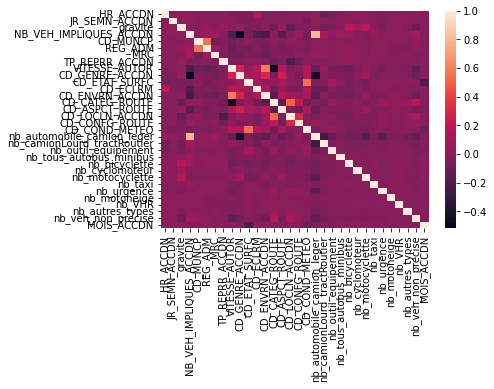

In [13]:
# Evaluation de la corrélation entre les attributs

corr_df = df_data.copy()
enc = LabelEncoder()
for col in corr_df.columns:
    if corr_df[col].dtype == 'object':
        corr_df[col] = enc.fit_transform(corr_df[col]) # Encodage pour les données catégoriques

corr = corr_df.iloc[:, :-1].corr()
# Heatmap pour visualiser les corrélations
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)
plt.show()

# Développement des modèles

## Vérifier l'équilibre des classes
On remarque dans l'histogramme ci-dessous que les classes sont grandement déséquilibrées. En effet, la classe des accidents "Dommages_materiels" est dominante par rapport aux autres : de 70 000 accidents contre ~19 000 accidents "Légers" puis le reste est partagé entre accidents "Graves" et "Mortels".

Pour palier à ce déséquilibre, nous utiliserons une pondération dans nos modèles pour rééquilibrer nos classes. En effet, notre objectif n'est pas seulement de prédire la gravité de l'accident (auquel cas on risquerait de prédire dans la grande majorité des cas un accident avec dommages matériels) mais également de bien mettre en évidence les caractériques de chaque type d'accident. 

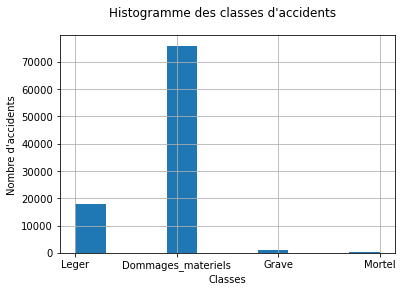

In [14]:
# Affichage d'un histogramme pour évaluer l'équilibre entre les classes
class_hist = df_data["gravite"].hist()
plt.suptitle("Histogramme des classes d'accidents")
plt.ylabel("Nombre d'accidents")
plt.xlabel("Classes")
plt.show()

## Sets d'Entrainement/Test

In [15]:
from sklearn import preprocessing
def split_dataset(df, test_size, output_col='gravite', encoding='OneHot', set_seed=None):
    '''
      Fonction pour diviser le dataset en set d'entrainement et set de test.

      INPUTS
      -----
      df : un dataframe
      test_size : le % de taille du set de test
      output_col : la colonne correspondant à la variable de sortie
      encoding : 'None' pour pas d'encodage. 'Onehot' pour un encodage one-hot. 'LabelEncoder' pour un encodage numérique. 
      set_seed : Seed permettant la reproductibilité du résultat

      OUTPUTS
      -----
      X : dataframe contenant l'ensemble des prédicteurs
      Y : dataframe contenant uniquement la variable de sortie
      X_train : dataframe d'entrainement contenant les prédicteurs
      Y_train : dataframe d'entrainement contenant la variable de sortie
      X_test : dataframe de test contenant les prédicteurs
      Y_test : dataframe de test contenant la variable de sortie
    '''
    if encoding == 'LabelEncoder':
        cat_col = df.select_dtypes(include="object")
        Label_encoder = preprocessing.LabelEncoder()
        for col in cat_col:
            if col != output_col:
                df[col] = Label_encoder.fit_transform(df[col])

    Y = df[output_col]
    X = df.loc[:, df.columns != output_col]

    if encoding == 'OneHot':
        X = pd.get_dummies(X,drop_first=True)

    # Division du dataset en set d'entrainement et de test
    if set_seed is not None:
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state=set_seed)
    else:
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size)
  
    #X_train, X_test = pd.get_dummies(X_train), pd.get_dummies(X_test)
    return X, Y, X_train, X_test, Y_train, Y_test

X, Y, X_train, X_test, Y_train, Y_test = split_dataset(df_data, 0.30, 'gravite',encoding='OneHot', set_seed=204)

## Arbre de décision

In [16]:
# Réalisation d'une validation croisée afin d'obtenir la profondeur d'arbre optimale
kf = KFold(n_splits=5)

depth = []
#X_one_hot_data = pd.get_dummies(X,drop_first=True)
for i in range(2,10,1):
    print("... CV avec une profondeur max de =", i,"...")
    decision_tree = tree.DecisionTreeClassifier(criterion = 'gini', max_depth=i, min_samples_leaf=1, class_weight='balanced',random_state=2)
    # Perform 5-fold cross validation 
    scores = cross_val_score(decision_tree,X,Y, cv=kf, scoring='precision_micro',n_jobs=4)
    depth.append((i,scores.mean()))
print("Done.")

... CV avec une profondeur max de = 2 ...
... CV avec une profondeur max de = 3 ...
... CV avec une profondeur max de = 4 ...
... CV avec une profondeur max de = 5 ...
... CV avec une profondeur max de = 6 ...
... CV avec une profondeur max de = 7 ...
... CV avec une profondeur max de = 8 ...
... CV avec une profondeur max de = 9 ...
Done.


In [17]:
depth_score = pd.DataFrame(depth, columns=['depth', 'precision'])
print(depth_score)

   depth  precision
0      2   0.456312
1      3   0.573512
2      4   0.609924
3      5   0.607549
4      6   0.555173
5      7   0.524157
6      8   0.567634
7      9   0.525934


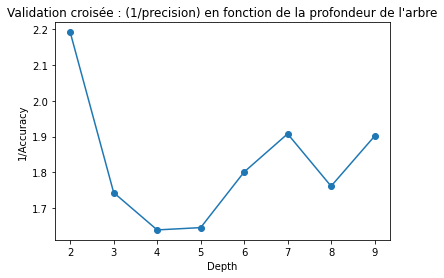

La valeur optimal pour la profondeur est de 4 avec une précision de : 60.99 %


In [18]:
# Affichage du résultat de la validation croisée
plt.plot(depth_score['depth'],1/depth_score['precision'], '-o')
plt.xlabel("Depth")
plt.ylabel("1/Accuracy")
plt.title("Validation croisée : (1/precision) en fonction de la profondeur de l'arbre")
plt.show()

depth_optim, depth_optim_precision = depth_score[depth_score.precision == depth_score.precision.max()]['depth'].values[0], depth_score[depth_score.precision == depth_score.precision.max()]['precision'].values[0]

print("La valeur optimal pour la profondeur est de", depth_optim,"avec une précision de :", round(depth_optim_precision*100, 2), "%")


--------------- Learning performances -----------------------

Confusion Matrix: 



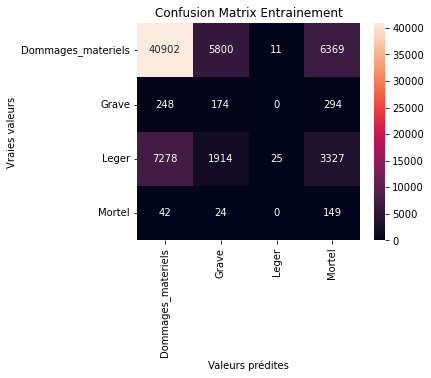

Précision :  61.98 %

Recall :  42.71 %


--------------- Validation performances ---------------------

Confusion Matrix: 



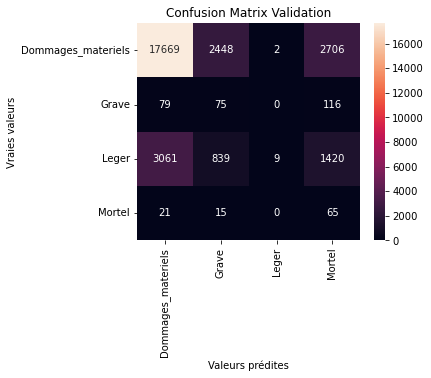

Précision :  62.46 %

Recall :  42.43 %



In [19]:
# Ajustement d'un arbre de classification optimal et affichage des résulats de l'entrainement et de la validation
best_model_tree = tree.DecisionTreeClassifier(criterion = 'gini', max_depth=depth_optim, min_samples_leaf=1, class_weight='balanced',random_state=200)
clf = best_model_tree.fit(X_train , Y_train)
class_levels = Y.unique()
class_levels[0],class_levels[1],class_levels[2],class_levels[3] = class_levels[1],class_levels[2],class_levels[0],class_levels[3]
print("\n--------------- Learning performances -----------------------\n") 
# Predictions
Y_train_pred = clf.predict(X_train)
# Afficher les resultats
print("Confusion Matrix: \n") 
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(Y_train, Y_train_pred), annot=True, fmt="g",  yticklabels=class_levels, xticklabels=class_levels)

plt.title('Confusion Matrix Entrainement')
plt.ylabel('Vraies valeurs')
plt.xlabel('Valeurs prédites')
plt.show()
print ("Précision : ", round(accuracy_score(Y_train, Y_train_pred)*100,2), '%\n') 
print ("Recall : ", round(recall_score(Y_train, Y_train_pred, average="macro")*100,2),'%\n')

print("\n--------------- Validation performances ---------------------\n") 
# Predictions
Y_test_pred = clf.predict(X_test)
# Afficher les resultats
print("Confusion Matrix: \n") 
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(Y_test, Y_test_pred), annot=True, fmt="g",  yticklabels=class_levels, xticklabels=class_levels)

plt.title('Confusion Matrix Validation')
plt.ylabel('Vraies valeurs')
plt.xlabel('Valeurs prédites')
plt.show()
print ("Précision : ", round(accuracy_score(Y_test, Y_test_pred)*100,2),'%\n')
print ("Recall : ", round(recall_score(Y_test, Y_test_pred, average="macro")*100,2),'%\n')

## Fôrets aléatoires

In [20]:
'''
Réalisation d'une validation croisée afin d'obtenir la profondeur d'arbre optimale
et le nombre d'arbres optimal pour Random Forest

--> PEUT PRENDRE BEAUCOUP DE TEMPS
Un long test a été fait avec 
param_grid = {
    'max_depth': [i for i in range(5,20,5)],
    'n_estimators': [i for i in range(100,600,100)]
}
>>>> Résultat : 
La valeur optimale pour la profondeur est de 15 avec 300 arbres et une précision de : 68.22 %

Etant donné le temps de calcul qui peut être long, nous avons fait le choix
de fixer le nombre max de prédicteurs à sqrt(nombre_total_de_predicteurs).
'''

# Création d'une grille de paramètres pour la validation croisée
param_grid = {
    'max_depth': [15],
    'n_estimators': [300],
    'max_features': [int(np.sqrt(X.shape[1]))]
}
# Création du modèle de Random Forest
rf = RandomForestClassifier(criterion = "entropy", bootstrap=True, min_samples_leaf=1, class_weight='balanced',random_state=204)
# GridSearch avec une validation croisée à 5 folds
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = 4, verbose=3)

In [21]:
# Ajustement sur les données d'entrainement
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy',
                                              random_state=204),
             n_jobs=4,
             param_grid={'max_depth': [15], 'max_features': [38],
                         'n_estimators': [300]},
             verbose=3)

In [22]:
# Affichage des paramètres optimaux obtenus
best_rf_depth, ntrees, best_rf_nfeatures = grid_search.best_params_['max_depth'], grid_search.best_params_['n_estimators'], grid_search.best_params_['max_features']
rf_cv_best_accuracy = grid_search.best_score_
print("Random Forest : La valeur optimale pour la profondeur est de", best_rf_depth,"avec",ntrees,"arbres et", best_rf_nfeatures,"prédicteurs pour une précision de :", round(rf_cv_best_accuracy*100, 2), "%")

Random Forest : La valeur optimale pour la profondeur est de 15 avec 300 arbres et 38 prédicteurs pour une précision de : 70.16 %



--------------- Learning performances -----------------------

Confusion Matrix: 



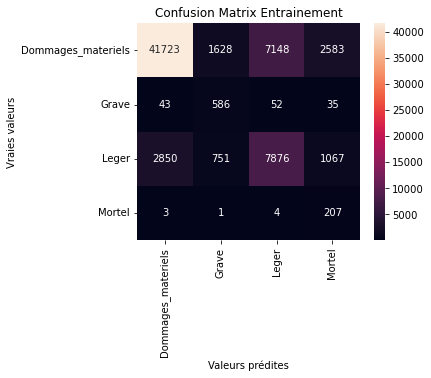

Précision :  75.71 %

Recall :  79.88 %


--------------- Validation performances ---------------------

Confusion Matrix: 



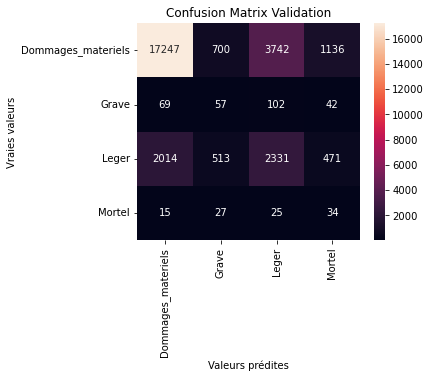

Précision :  68.95 %

Recall :  43.52 %



In [23]:
# Ajustement d'un modèle Random Forest optimal et affichage des résulats de l'entrainement et de la validation

best_rf = RandomForestClassifier(max_depth=best_rf_depth,n_estimators=ntrees, max_features= best_rf_nfeatures ,criterion = "entropy", bootstrap=True, min_samples_leaf=1, class_weight='balanced',random_state=204)
rf_clf = best_rf.fit(X_train , Y_train)
class_levels = Y.unique()
class_levels[0],class_levels[1],class_levels[2],class_levels[3] = class_levels[1],class_levels[2],class_levels[0],class_levels[3]
print("\n--------------- Learning performances -----------------------\n") 
# Predictions
Y_train_pred = rf_clf.predict(X_train)
# Afficher les resultats
print("Confusion Matrix: \n") 
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(Y_train, Y_train_pred), annot=True, fmt="g",  yticklabels=class_levels, xticklabels=class_levels)

plt.title('Confusion Matrix Entrainement')
plt.ylabel('Vraies valeurs')
plt.xlabel('Valeurs prédites')
plt.show()
print ("Précision : ", round(accuracy_score(Y_train, Y_train_pred)*100,2), '%\n') 
print ("Recall : ", round(recall_score(Y_train, Y_train_pred, average="macro")*100,2),'%\n')

print("\n--------------- Validation performances ---------------------\n") 
# Predictions
Y_test_pred = rf_clf.predict(X_test)
# Afficher les resultats
print("Confusion Matrix: \n") 
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(Y_test, Y_test_pred), annot=True, fmt="g",  yticklabels=class_levels, xticklabels=class_levels)

plt.title('Confusion Matrix Validation')
plt.ylabel('Vraies valeurs')
plt.xlabel('Valeurs prédites')
plt.show()
print ("Précision : ", round(accuracy_score(Y_test, Y_test_pred)*100,2),'%\n')
print ("Recall : ", round(recall_score(Y_test, Y_test_pred, average="macro")*100,2),'%\n')